# Loading the Data

We start by loading the data from our google drive. If you are not using Google Colab to execute this code and are storing your copy of the data locally, simply delete the first five lines of code in the first block and replace the directory in the getDF call with the location of the file in your local directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/nn")

import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Automotive_5.json.gz')

Mounted at /content/drive


In [ ]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4.0,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"
...,...,...,...,...,...,...,...,...,...
20468,A1KB43BI085A48,B00KIAQ8VW,Mike F.,"[1, 1]",I've bought 10 of these over the past year to ...,5.0,Excellent quality for the price,1396915200,"04 8, 2014"
20469,A3HIUWKL4D853W,B00KIAQ8VW,RayH,"[0, 0]","OK, I have to admit, the price of this item di...",2.0,Light weight neck and face cover with whimsica...,1391472000,"02 4, 2014"
20470,A1S95WASXJ02VX,B00KIAQ8VW,Roberto Aguilar Jr.,"[0, 0]",I love my skull face mask. It makes me outstan...,5.0,I love to ride with my Skull Face Mask.,1386547200,"12 9, 2013"
20471,A2IID0Z6EHF5KP,B00KIAQ8VW,Soarer,"[0, 0]",This mask of course as described is half-face ...,5.0,Great neck protection,1357171200,"01 3, 2013"


We add a column that translates a user's review from a 1-5 scale score into a binary classifier with zero being assigned for scores less than three, representing negative sentiment, and one being assigned for scores of three or higher, representing positive sentiment.

In [ ]:
df['sentiment'] = df.overall.apply(lambda x: 0 if x in [1,2] else 1)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011",1
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4.0,Okay long cables,1315094400,"09 4, 2011",1
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013",1
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010",1
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012",1
...,...,...,...,...,...,...,...,...,...,...
20468,A1KB43BI085A48,B00KIAQ8VW,Mike F.,"[1, 1]",I've bought 10 of these over the past year to ...,5.0,Excellent quality for the price,1396915200,"04 8, 2014",1
20469,A3HIUWKL4D853W,B00KIAQ8VW,RayH,"[0, 0]","OK, I have to admit, the price of this item di...",2.0,Light weight neck and face cover with whimsica...,1391472000,"02 4, 2014",0
20470,A1S95WASXJ02VX,B00KIAQ8VW,Roberto Aguilar Jr.,"[0, 0]",I love my skull face mask. It makes me outstan...,5.0,I love to ride with my Skull Face Mask.,1386547200,"12 9, 2013",1
20471,A2IID0Z6EHF5KP,B00KIAQ8VW,Soarer,"[0, 0]",This mask of course as described is half-face ...,5.0,Great neck protection,1357171200,"01 3, 2013",1


# Import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Non-Standard Characters

We see from the lack of output that no non-ASCII characters are detected.

In [ ]:
import string

def non_ascii(text):
    char_set = string.printable
    return all((True if x in char_set else False for x in text))

for text in df['reviewText']:
  if not non_ascii(text):
    print(text)

# Vocabulary and Embedding Size

We use a tokenizer to tokenize the words in our dataset so they can be counted. We will use this tokenizer again later.

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['reviewText'])
word_index = tokenizer.word_index

vocab_size = len(word_index) + 1
vocab_size

29304

B.1.c

https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

The vocabulary size is used to calculate the dimensions for embedding that will be used in the first layer of our neural network.

In [ ]:
embedding_dim =  int(np.round(vocab_size**0.25))

# Review Length

In [ ]:
review_length = df['reviewText'].apply(lambda x: len(x))
mean_length = np.mean(df['reviewText'].apply(lambda x: len(x)))
median_length = np.median(df['reviewText'].apply(lambda x: len(x)))
q3 = np.quantile(review_length, 0.75)

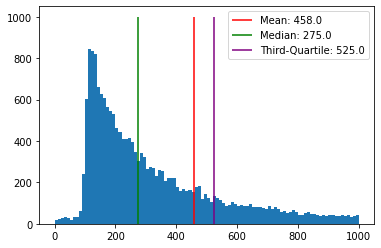

In [ ]:
plt.hist(review_length, bins=100, range=(0, 1000))
plt.vlines(mean_length, ymin=0, ymax=1000, colors='red', label='Mean: ' + str(np.round(mean_length)))
plt.vlines(median_length, ymin=0, ymax=1000, colors='green', label='Median: ' + str(np.round(median_length)))
plt.vlines(q3,  ymin=0, ymax=1000, colors='purple', label='Third-Quartile: ' + str(np.round(q3)))
plt.legend()

We can see that the median is much lower than the mean, implying we have a small number of very long reviews. The third quartile is much closer to the mean than the median is. Because of this, we will set the maximum sequence length to the third quartile value, rounded to the nearest integer.

In [ ]:
max_length = int(q3)

# Train-Test-Val Split

We will allot 60% of the initial dataset for training, 20% for testing, and the final 20% for validation.

In [ ]:
split1 = round(len(df)*0.6)
split2 = round(len(df)*0.8)
train_reviews = df['reviewText'][:split1]
train_label = df['sentiment'][:split1]
test_reviews = df['reviewText'][split1:split2]
test_label = df['sentiment'][split1:split2]
val_reviews = df['reviewText'][split2:]
val_label = df['sentiment'][split2:]

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
val_sentences = []
val_labels = []
for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)
for row in val_reviews:
    val_sentences.append(str(row))
for row in val_label:
    val_labels.append(row)

# Tokenization and Padding/Trimming

We use the previously determined sequence length to trim overly-long reviews and pad shorter reviews so that every review contains 525 words. These words are also tokenized, meaning each unique word is assigned a numeric key so that the model can interpret the data.

In [ ]:
trunc_type = 'post'
padding_type = 'post'

In [ ]:
sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
print(sequences[0])

padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)
print(padded[0])

[5, 220, 6, 200, 8, 1969, 693, 11, 14, 102, 29, 3, 28, 51, 39, 346, 3, 127, 43, 6, 39, 89, 25, 18, 113, 50, 6, 146, 283, 475, 3, 54, 79, 25, 22, 759, 4, 57, 1262, 76, 79, 5, 33, 190, 9, 15, 440, 1065, 77, 404, 58, 1992, 716, 123, 31, 16, 480, 40, 284, 707, 4, 284, 707, 25, 22, 878, 103, 19, 6, 157, 8, 283, 16, 33, 26, 5192, 187, 29, 32, 235, 53, 77, 567, 92, 8, 10, 5, 52, 124, 243, 6, 86, 299, 56, 5772, 41, 334, 53, 7431, 756, 244]
[   5  220    6  200    8 1969  693   11   14  102   29    3   28   51
   39  346    3  127   43    6   39   89   25   18  113   50    6  146
  283  475    3   54   79   25   22  759    4   57 1262   76   79    5
   33  190    9   15  440 1065   77  404   58 1992  716  123   31   16
  480   40  284  707    4  284  707   25   22  878  103   19    6  157
    8  283   16   33   26 5192  187   29   32  235   53   77  567   92
    8   10    5   52  124  243    6   86  299   56 5772   41  334   53
 7431  756  244    0    0    0    0    0    0    0    0    0    0  

The sentiments are converted to numpy arrays in order to properly align with model requirements.

In [ ]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
val_labels_final = np.array(val_labels)

# Data Output

The cleaned data and labels are saved for later use.

In [ ]:
train_df = pd.DataFrame(padded)
test_df = pd.DataFrame(testing_padded)
val_df = pd.DataFrame(val_padded)
train_lab_df = pd.DataFrame(training_labels_final)
test_lab_df = pd.DataFrame(testing_labels_final)
val_lab_df = pd.DataFrame(val_labels_final)

train_df.to_csv('train.csv')
test_df.to_csv('test.csv')
val_df.to_csv('val.csv')
train_lab_df.to_csv('train_lab.csv')
test_lab_df.to_csv('test_lab.csv')
val_lab_df.to_csv('val_lab.csv')

# Model

Our model has three layers: an embedding layer, a long short-term memory (LSTM) layer, and a dense layer. The embedding layer is our input layer, accepting the sequences and outputting each sequence as an array of shape 512 by 13. This contains all of the word embeddings for the sequence and feeds these into the LSTM layer. There are 380,952 trainable parameters for this layer, allowing for a large amount of fine tuning as the model trains. The LSTM layer provides the recursion that makes this a recursive neural network and allows the model to interpret the meaning of the sequence in a sequential manner rather than as a group of unordered words. This layer compresses the data down to 100 outputs. This layer has 45,600 trainable parameters, further refining our model’s ability to predict sentiment accurately. Finally, our dense layer operates as the output layer, accepting the 100 outputs from the LSTM layer and outputting only one value. There are 101 parameters to tune for this layer, allowing for minimal tuning in the final steps of the prediction. This layer has a single output that activates with a sigmoid function and makes the binary classification of sentiment. We have a total of 426,653 parameters that are all trainable.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(100, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 525, 13)           380952    
                                                                 
 lstm (LSTM)                 (None, 100)               45600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 426,653
Trainable params: 426,653
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 25
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(val_padded, val_labels_final), callbacks=[es])

Epoch 1/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2091 - accuracy: 0.9468 - val_loss: 0.2158 - val_accuracy: 0.9441
Epoch 2/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2089 - accuracy: 0.9468 - val_loss: 0.2178 - val_accuracy: 0.9441
Epoch 3/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2087 - accuracy: 0.9468 - val_loss: 0.2157 - val_accuracy: 0.9441
Epoch 4/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2085 - accuracy: 0.9468 - val_loss: 0.2156 - val_accuracy: 0.9441
Epoch 5/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2086 - accuracy: 0.9468 - val_loss: 0.2166 - val_accuracy: 0.9441
Epoch 6/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2083 - accuracy: 0.9468 - val_loss: 0.2157 - val_accuracy: 0.9441
Epoch 7/25
384/384 [==============================] - 11s 28ms/step - loss: 0.2087 - accuracy: 0.9467 - val_loss: 0.2164 - val_accuracy:

The model finishes training before the maximum epochs are completed, ensuring that the model does not overfit the training data.

<Figure size 432x288 with 0 Axes>

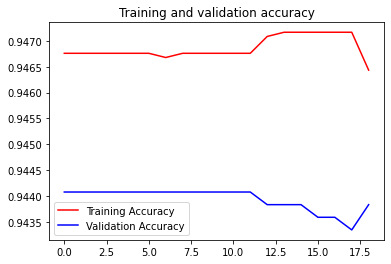

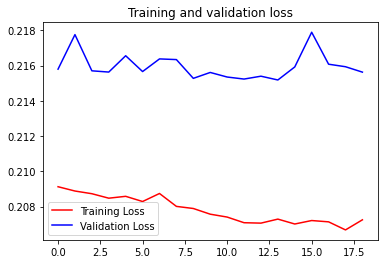

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

We see that there was only minimal improvement on the valdation data over time and actually began to worsen after the first ten epochs.

Our accuracy scores suggest that our model is performing well, successfully predicting the sentiment of 93.5% of the testing data.

In [ ]:
_, train_acc = model.evaluate(padded, training_labels_final, verbose=0)
_, test_acc = model.evaluate(testing_padded, testing_labels_final, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.947, Test: 0.935


Finally, we save the weights of the model so they can be reinitialized later in future projects.

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

This final piece of code is used to export the notebook to pdf format from Google Colab.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

!cp drive/My Drive/Colab Notebooks/Untitled.ipynb ./

In [ ]:
!jupyter nbconvert --to PDF "Task_2.ipynb"

[NbConvertApp] Converting notebook Task_2.ipynb to PDF
[NbConvertApp] Support files will be in Task_2_files/
[NbConvertApp] Making directory ./Task_2_files
[NbConvertApp] Making directory ./Task_2_files
[NbConvertApp] Making directory ./Task_2_files
[NbConvertApp] Writing 62294 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 84434 bytes to Task_2.pdf
